In [4]:
import os
import sys
import math
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols
import umap

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
liked_songs = pd.read_csv("../data/external/liked_songs_augmented.csv")

In [10]:
(liked_songs["count"] == 0).sum()

1115

In [11]:
len(liked_songs)

1845

In [12]:
not_listened_ratio = (liked_songs["count"] == 0).sum() / liked_songs["count"].shape[0]
not_listened_ratio

0.6043360433604336

## Feature Preprocessing

- Log-transformed listen counts to be used as weights for features
- transform proper features to be on approximately the same scale
- compute user representation as the weighted mean of music features (based on listened songs)
- create a search token and compute the songs with the minimum distance (cosine) (from unlistened songs)

In [13]:
unscaled_attributes = [
    "key",
    "loudness",
    "tempo"
]

scaled_attributes = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "mode",
    "valence"
]

In [14]:
not_listened = (liked_songs["count"] == 0).values

weights = np.log1p(liked_songs["count"]).values.reshape(-1, 1)

feature_cols = scaled_attributes + unscaled_attributes
features = liked_songs[feature_cols].copy()
features["key"] = features["key"] / 11
# log-transformation, log-normal dist, currently: min-max-scaling
features["loudness"] = -(features["loudness"] - features["loudness"].min()) / (features["loudness"].min() - features["loudness"].max())
features["tempo"] = (features["tempo"] - features["tempo"].min()) / (features["tempo"].max() - features["tempo"].min())
features = features.values

In [15]:
features

array([[0.67      , 0.75      , 0.0583    , ..., 0.54545455, 0.93779361,
        0.39075144],
       [0.202     , 0.374     , 0.0311    , ..., 0.36363636, 0.89050643,
        0.82967465],
       [0.328     , 0.219     , 0.0337    , ..., 0.81818182, 0.71249118,
        0.65738223],
       ...,
       [0.241     , 0.613     , 0.0336    , ..., 0.18181818, 0.85800079,
        0.65623437],
       [0.549     , 0.859     , 0.0361    , ..., 0.45454545, 0.96376026,
        0.36680368],
       [0.582     , 0.879     , 0.0345    , ..., 0.36363636, 0.97052295,
        0.543035  ]])

In [16]:
user = (features*weights).sum(axis=0) / weights.sum().reshape(1, -1)

In [17]:
user

array([[0.5279965 , 0.60584396, 0.04880975, 0.27162006, 0.18682597,
        0.15971701, 0.42309456, 0.3779277 , 0.50443943, 0.88566303,
        0.57681643]])

In [18]:
# compute cosine similarities between user and song representations
similarities = (features*user).sum(axis=1) / (np.sqrt(np.sum(np.square(user))) * np.sqrt(np.sum(np.square(features), axis=1)))

/var/folders/r7/8gx_1_2s5d555mdj1sqz93c40000gn/T/ipykernel_49504/874241376.py:2: RuntimeWarning: invalid value encountered in true_divide
  similarities = (features*user).sum(axis=1) / (np.sqrt(np.sum(np.square(user))) * np.sqrt(np.sum(np.square(features), axis=1)))


In [19]:
similarities

array([0.90693585, 0.78897895, 0.84888934, ..., 0.85204097, 0.92300198,
       0.9087947 ])

(array([  1.,   1.,   3.,   0.,   3.,   7.,   4.,   4.,   6.,   9.,  11.,
          5.,  12.,  16.,  21.,  16.,  19.,  23.,  15.,  17.,  25.,  33.,
         39.,  44.,  70.,  70.,  79., 111., 130., 174., 196., 212., 212.,
        185.,  55.,  16.]),
 array([0.58600824, 0.59643916, 0.60687008, 0.617301  , 0.62773192,
        0.63816284, 0.64859376, 0.65902468, 0.6694556 , 0.67988652,
        0.69031744, 0.70074836, 0.71117928, 0.7216102 , 0.73204112,
        0.74247204, 0.75290296, 0.76333388, 0.7737648 , 0.78419572,
        0.79462664, 0.80505756, 0.81548848, 0.8259194 , 0.83635032,
        0.84678124, 0.85721216, 0.86764308, 0.878074  , 0.88850492,
        0.89893584, 0.90936676, 0.91979768, 0.9302286 , 0.94065952,
        0.95109044, 0.96152136]),
 <BarContainer object of 36 artists>)

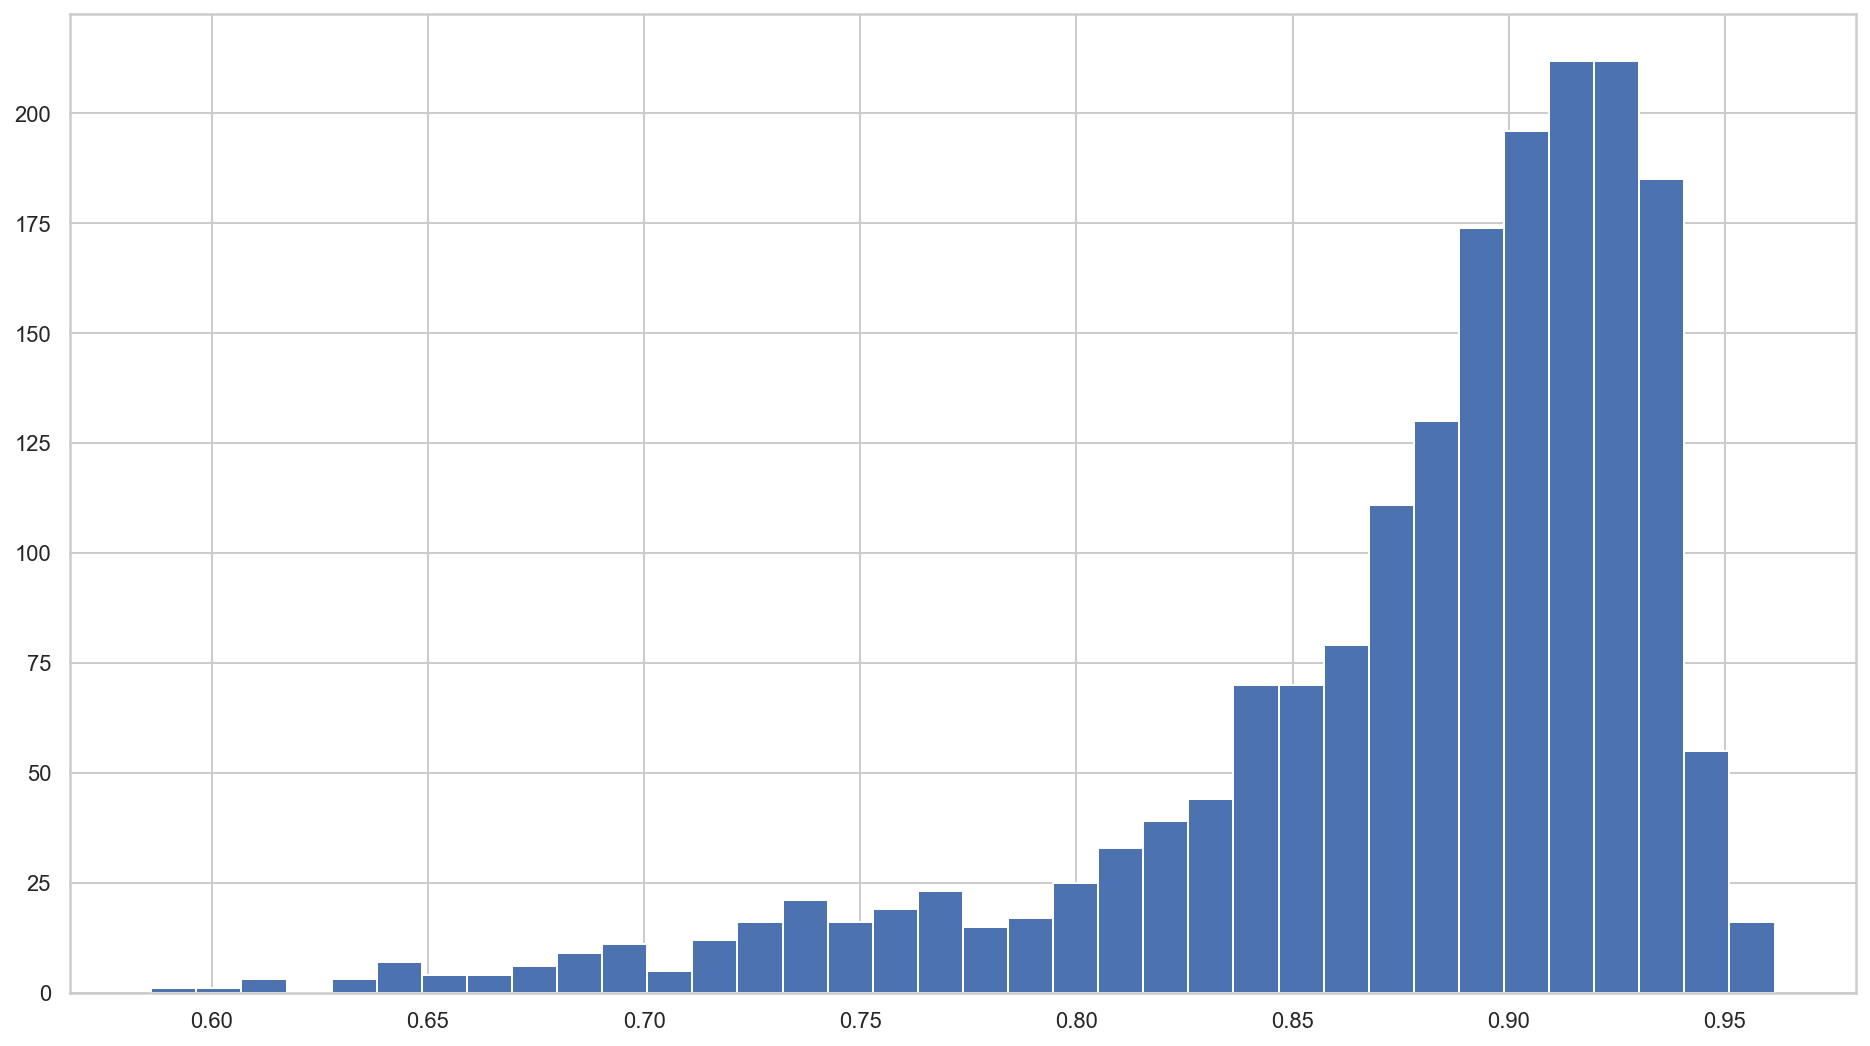

In [20]:
plt.hist(similarities, bins="auto")

In [23]:
len(similarities)

1845

In [24]:
# compute ranking of songs and distill to non-listened
order = np.argsort(similarities)[::-1]
order = [val for val in order if val in np.where(not_listened)[0]]
len(order)

1115

In [27]:
top_k = 20
new_playlist = liked_songs.loc[order[20:20+top_k]]

In [28]:
new_playlist

,artist,album,track_x,uri,id,artist_track,track_y,count,date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,track_href,analysis_url,duration_ms,time_signature
1279,SMOLIK / KEV FOX,SMOLIK / KEV FOX,Run,spotify:track:6tVGyszugxw0PLzBshkg7t,6tVGyszugxw0PLzBshkg7t,SMOLIK / KEV FOX: Run,NaN,0.0,NaN,0.744,0.792,7,-5.586,0,0.0435,0.411000,0.000273,0.0771,0.367,117.965,audio_features,https://api.spotify.com/v1/tracks/6tVGyszugxw0...,https://api.spotify.com/v1/audio-analysis/6tVG...,222693,4
1511,The Cure,Greatest Hits,Lovesong,spotify:track:49edirvFZwWjxAMZJRg1hN,49edirvFZwWjxAMZJRg1hN,The Cure: Lovesong,NaN,0.0,NaN,0.580,0.869,9,-4.349,0,0.0297,0.375000,0.276000,0.1590,0.736,139.945,audio_features,https://api.spotify.com/v1/tracks/49edirvFZwWj...,https://api.spotify.com/v1/audio-analysis/49ed...,206907,4
265,Cecilia Krull,My Life Is Going On (Música Original De La Ser...,My Life Is Going On (Música Original De La Ser...,spotify:track:5ZEQjTroORCu6uWvZrdeNc,5ZEQjTroORCu6uWvZrdeNc,Cecilia Krull: My Life Is Going On (Música Ori...,NaN,0.0,NaN,0.427,0.647,6,-8.944,0,0.0353,0.102000,0.000002,0.1330,0.298,99.753,audio_features,https://api.spotify.com/v1/tracks/5ZEQjTroORCu...,https://api.spotify.com/v1/audio-analysis/5ZEQ...,214200,4
1724,The Killers,Sam's Town,Bones,spotify:track:6TUd6BeKaEvhakhh6T2YJW,6TUd6BeKaEvhakhh6T2YJW,The Killers: Bones,NaN,0.0,NaN,0.472,0.902,9,-3.607,1,0.0643,0.000679,0.124000,0.0822,0.567,139.570,audio_features,https://api.spotify.com/v1/tracks/6TUd6BeKaEvh...,https://api.spotify.com/v1/audio-analysis/6TUd...,227000,4
1580,The Killers,Sam's Town,Bones,spotify:track:4shKoD4U0rsE6UDjyPEjyK,4shKoD4U0rsE6UDjyPEjyK,The Killers: Bones,NaN,0.0,NaN,0.472,0.902,9,-3.607,1,0.0643,0.000679,0.124000,0.0822,0.567,139.570,audio_features,https://api.spotify.com/v1/tracks/4shKoD4U0rsE...,https://api.spotify.com/v1/audio-analysis/4shK...,227000,4
233,Macklemore,The Unplanned Mixtape,And We Danced (feat. Ziggy Stardust),spotify:track:1FCQEg7wOK9IIBuxx63krr,1FCQEg7wOK9IIBuxx63krr,Macklemore: And We Danced (feat. Ziggy Stardust),NaN,0.0,NaN,0.758,0.677,5,-6.598,1,0.0782,0.456000,0.000000,0.0954,0.713,124.998,audio_features,https://api.spotify.com/v1/tracks/1FCQEg7wOK9I...,https://api.spotify.com/v1/audio-analysis/1FCQ...,246213,4
159,U2,Songs Of Innocence,The Troubles - Alternative Version,spotify:track:0XKClTokiXeQ6XTv4WxWJk,0XKClTokiXeQ6XTv4WxWJk,U2: The Troubles - Alternative Version,NaN,0.0,NaN,0.409,0.634,6,-9.432,1,0.0373,0.207000,0.051900,0.1260,0.375,150.014,audio_features,https://api.spotify.com/v1/tracks/0XKClTokiXeQ...,https://api.spotify.com/v1/audio-analysis/0XKC...,272305,4
349,Queen,Forever,Love Kills - The Ballad,spotify:track:2MAdGSEc0bs15KTuXPax0G,2MAdGSEc0bs15KTuXPax0G,Queen: Love Kills - The Ballad,NaN,0.0,NaN,0.496,0.792,7,-6.134,0,0.0418,0.115000,0.000026,0.1300,0.327,126.585,audio_features,https://api.spotify.com/v1/tracks/2MAdGSEc0bs1...,https://api.spotify.com/v1/audio-analysis/2MAd...,252613,4
130,Skunk Anansie,What You Do For Love,What You Do For Love,spotify:track:4rC6R0Dhe9LavndPwAt2B0,4rC6R0Dhe9LavndPwAt2B0,Skunk Anansie: What You Do For Love,NaN,0.0,NaN,0.598,0.689,8,-6.519,1,0.0637,0.000402,0.000004,0.1420,0.523,142.033,audio_features,https://api.spotify.com/v1/tracks/4rC6R0Dhe9La...,https://api.spotify.com/v1/audio-analysis/4rC6...,200934,4
1215,Malky,Where Is Piemont,Theodore,spotify:track:6Mq87hGdnLjM6nVQYoB98P,6Mq87hGdnLjM6nVQYoB98P,Malky: Theodore,NaN,0.0,NaN,0.516,0.503,4,-10.748,0,0.0429,0.110000,0.000002,0.1640,0.205,96.832,audio_features,https://api.spotify.com/v1/tracks/6Mq87hGdnLjM...,https://api.spotify.com/v1/audio-analysis/6Mq8...,213507,4


In [29]:
new_playlist.to_csv("../data/result/playlist_reco_1.csv", index=False)

## Visualize the User Representation and Audio Features

In [55]:
reducer = umap.UMAP(n_components=2, metric="cosine")
reducer.fit(features)
embeddings = reducer.transform(features)

user_embedding = reducer.transform(user)

In [57]:
listened = (liked_songs["count"] > 0).values

In [47]:
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

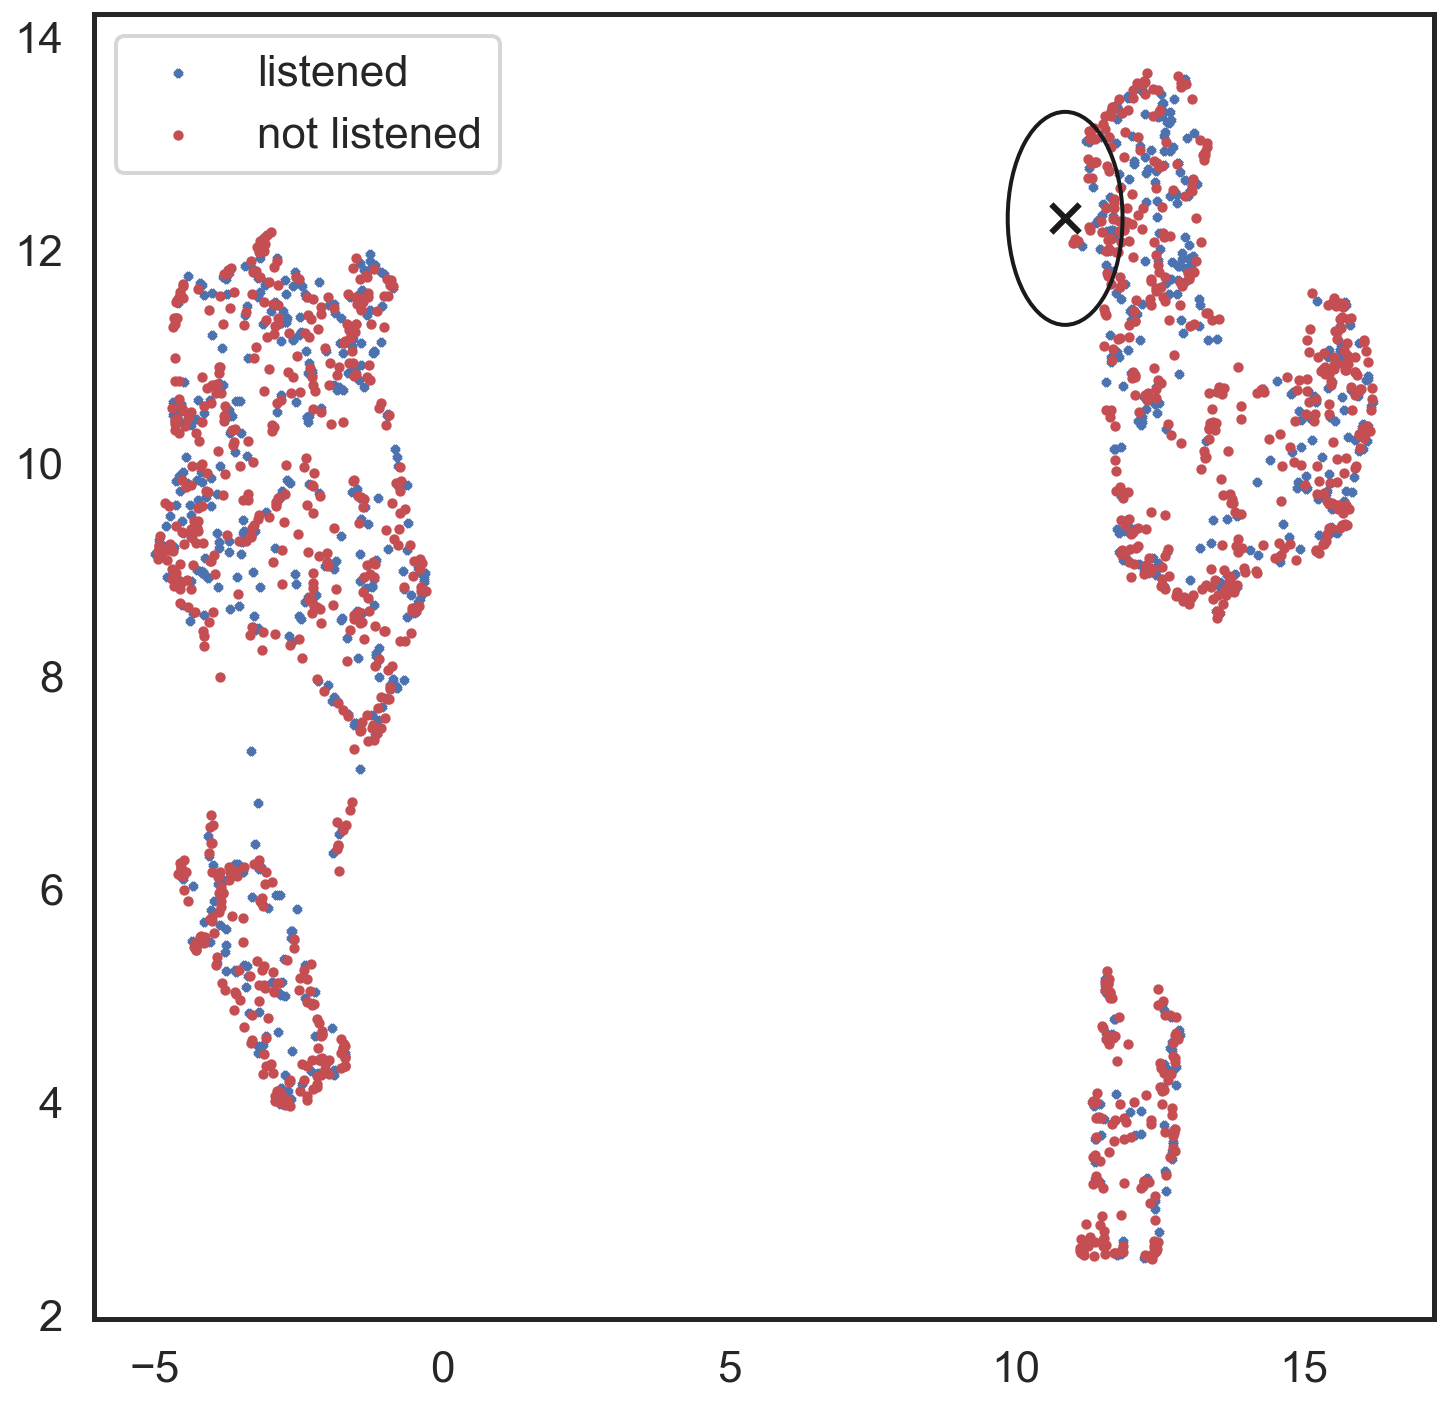

In [71]:
plt.figure(figsize=(12,12))
plt.scatter(embeddings[listened, 0], embeddings[listened, 1], s=10, marker="x", c="b", label="listened")
plt.scatter(embeddings[~listened, 0], embeddings[~listened, 1], s=10, marker="o", c="r", label="not listened")
plt.scatter(user_embedding[0, 0], user_embedding[0, 1], s=200, marker="x", c="k")
circle = plt.Circle(user_embedding[0], radius=1, color='k', fill=False)
# plt.grid(True)
plt.gca().add_artist(circle)
plt.legend()
plt.show()